# Natural Language Processing: Detecting Humor
## TP2 - IART - G44
- [Afonso Caiado, up201806789](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201806789)
- [Diogo Nunes, up201808546](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201808546)
- [João Pinto, up201806667](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201806667)

**It is recommended to [view this notebook in nbviewer](http://nbviewer.ipython.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) for the best viewing experience.**

**You can also [execute the code in this notebook on Binder](https://mybinder.org/v2/gh/rhiever/Data-Analysis-and-Machine-Learning-Projects/master?filepath=example-data-science-notebook%2FExample%20Machine%20Learning%20Notebook.ipynb) - no local installation required.**

## Table of contents

1. [Introduction](#Introduction)
2. [Required libraries](#Required-libraries)
3. [Checking the data](#Checking-the-data)
4. [Preprocessing the data](#Preprocessing-the-data)
    - [Porter Stemming](#Porter-Stemming)
    - [Snowball Stemming](#Snowball-Stemming)
    - [Lancaster Stemming](#Lancaster-Stemming)
    - [Lemmatization](#Lemmatization)
    - [Bag of words Model](#Bag-of-words-Model)
    - [Stemming or Lemmatization?](#Stemming-or-Lemmatization?)
5. [Applying machine learning algorithms](#Applying-machine-learning-algorithms)
6. [Conclusions](#Conclusions)
7. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Humor poses interesting linguistic challenges to NLP, due to its emphasis on multiple word senses, cultural knowledge, and pragmatic competence. Humor appreciation is also a highly subjective phenomenon, and each person can have a different perception of a joke. 

- Is the intention of the text do be humorous? (0 or 1). The first task, is a binary one. We simply have to predict if the text is considered humorous.  
- (If it is intended to be humorous) How humorous do you find it? (1 to 5). In this step, by emulating previous humor detection tasks with ratings and classification scores, we have to predict how humorous the text actually is (if it is humorous).

## Required libraries and imports

[[ go back to the top ]](#Table-of-contents)

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn
    
    conda install -c conda-forge watermark

`conda` may ask you to update some of them if you don't have the most recent version. Allow it to do so.

**Note:** We will not be providing support for people trying to run this notebook outside of the Anaconda Python distribution.

In [9]:
import pandas as pd
import seaborn as sb
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

## Checking the data

[[ go back to the top ]](#Table-of-contents)

In this section, we will import the datasets needed, check and analyse their content.

In [10]:
fields = ['id', 'is_humor', 'humor_rating', 'text']
# for this project, we don't need 'humor_controversy' and 'offense_rating'

# Importing the datasets
train_dataset = pd.read_csv('datasets/train.csv', usecols=fields, na_values=['NaN'])
dev_dataset = pd.read_csv('datasets/public_dev.csv')
test_dataset = pd.read_csv('datasets/public_test.csv')

In [11]:
# Train dataset head
train_dataset.head()

id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  
0          2.42  
1          2.50  
2          1.95  
3          2.11  
4          2.78

In [12]:
# Train dataset information
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            8000 non-null   int64  
 1   text          8000 non-null   object 
 2   is_humor      8000 non-null   int64  
 3   humor_rating  4932 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 250.1+ KB


As we can see, our train dataset has 4 relevant fields (for this project):
- **id**
- **text**
- **is_humor**
- **humor_rating**.

In [13]:
# Train dataset statistics
train_dataset.describe()

id     is_humor  humor_rating
count  8000.00000  8000.000000   4932.000000
mean   4000.50000     0.616500      2.260525
std    2309.54541     0.486269      0.566974
min       1.00000     0.000000      0.100000
25%    2000.75000     0.000000      1.890000
50%    4000.50000     1.000000      2.280000
75%    6000.25000     1.000000      2.650000
max    8000.00000     1.000000      4.000000

This table shows that our train dataset has:
- 8000 data lines;
- Curiously, there is no text evaluated with more than 4 in humor_rating column;
- The mean value of humor_rating is 2.26
- 61.6% of the dataset is considered humoristic.

<AxesSubplot:xlabel='is_humor', ylabel='count'>

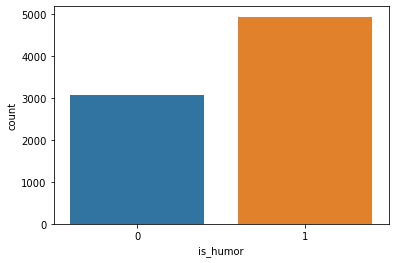

In [14]:
sb.countplot(x='is_humor', data=train_dataset)

<AxesSubplot:xlabel='humor_rating', ylabel='count'>

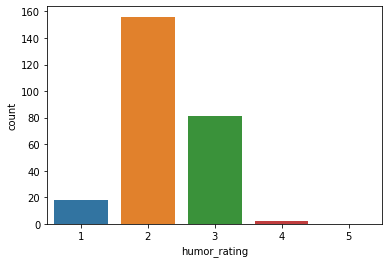

In [15]:
sb.countplot(x='humor_rating', order=[1,2,3,4,5], data=train_dataset)

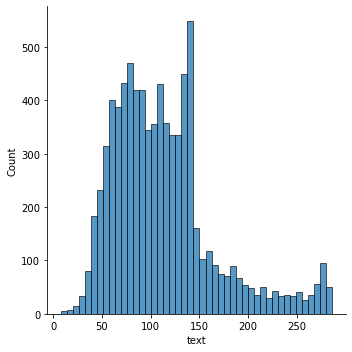

In [16]:
train_len = train_dataset['text'].apply(len)
sb.displot(train_len)

## Preprocessing the data

[[ go back to the top ]](#Table-of-contents)

Now, we will do some tasks needed before applying machine learning algorithms:
1. Clean the 'text' column, by removing non-alphanumeric characters;
2. Lowercase and tokenize it;
3. Stem and remove all stopwords;
4. Create bag-of-words model.

For that, we will present 3 stemming techniques and lemmatization.

### Porter Stemming

This preprocessing technique is known as one of the simplest and fastest, commonly used in Information Retrieval systems research, where the experiments need to be exactly repeatable.

In [25]:
def porterStemming():
    corpus = []
    ps = PorterStemmer()

    for i in range(0, 8000):
        text = re.sub('[^a-zA-Z]', ' ', train_dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)
    
    return corpus

ps = porterStemming()
print(ps)

['tennesse best state nobodi even come close elevennesse walk room tennesse oh shit', 'man insert advertis classifi wife want next day receiv repli read mine free deliveri also avail door step', 'mani men take open beer none open time bring couch', 'told mom hit twitter follow point brother own hous want sever collect agenc oh', 'rose dead love fake wed basic funer cake', 'trabajo spanish word work come latin term trepaliar mean tortur', 'enrol skill train extra curricula activ ad shape weekend work schedul day pass expos blindli love obsess month cool men', 'origin truli one kind also hold glass white wine love laugh', 'men ejacul time month lower risk prostat cancer ejacul four seven time month accord research harvard h chan school public health', 'got realli angri today noth go take word', 'dog mexico name frida save live peopl trap rubbl earthquak identifi total bodi throughout career consid nation heroin offici retir', 'differ mormon man muslim man mormon man get virgin kill', 'st

### Snowball Stemming

This technique can support other languages, that's why it's called a multi-lingual stemmer. This stemmer is based on a programming language called ‘Snowball’ that processes small strings and is the most widely used stemmer. The Snowball stemmer is way more aggressive than Porter Stemmer and is also referred to as Porter2 Stemmer. Because of the improvements added when compared to the Porter Stemmer, the Snowball stemmer is having greater computational speed. 

In [19]:
def snowballStemming():
    corpus = []
    ss = SnowballStemmer(language='english')

    for i in range(0, 8000):
        text = re.sub('[^a-zA-Z]', ' ', train_dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ss.stem(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)

    return corpus

ss = snowballStemming()
print(ss)

['tennesse best state nobodi even come close elevennesse walk room tennesse oh shit', 'man insert advertis classifi wife want next day receiv repli read mine free deliveri also avail door step', 'mani men take open beer none open time bring couch', 'told mom hit twitter follow point brother own hous want sever collect agenc oh', 'rose dead love fake wed basic funer cake', 'trabajo spanish word work come latin term trepaliar mean tortur', 'enrol skill train extra curricula activ ad shape weekend work schedul day pass expos blind love obsess month cool men', 'origin truli one kind also hold glass white wine love laugh', 'men ejacul time month lower risk prostat cancer ejacul four seven time month accord research harvard h chan school public health', 'got realli angri today noth go take word', 'dog mexico name frida save live peopl trap rubbl earthquak identifi total bodi throughout career consid nation heroin offici retir', 'differ mormon man muslim man mormon man get virgin kill', 'stop

### Lancaster Stemming

The Lancaster stemmers are more aggressive and dynamic compared to the other two stemmers. The stemmer is really faster, but the algorithm is really confusing when dealing with small words. But they are not as efficient as Snowball Stemmers. The Lancaster stemmers save the rules externally and basically uses an iterative algorithm. 

In [20]:
def lancasterStemming():
    corpus = []
    ls = LancasterStemmer()

    for i in range(0, 8000):
        text = re.sub('[^a-zA-Z]', ' ', train_dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ls.stem(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)
        
    return corpus

ls = lancasterStemming()
print(ls)

['ten best stat nobody ev com clos elev walk room ten oh shit', 'man insert advert class wif want next day receiv reply read min fre delivery also avail door step', 'many men tak op beer non op tim bring couch', 'told mom hit twit follow point broth own hous want sev collect ag oh', 'ros dead lov fak wed bas fun cak', 'trabajo span word work com latin term trepali mean tort', 'enrol skil train extr curricul act ad shap weekend work schedule day pass expos blind lov obsess month cool men', 'origin tru on kind also hold glass whit win lov laugh', 'men ejac tim mon low risk prost cant ejac four sev tim mon accord research harvard h chan school publ heal', 'got real angry today noth going tak word', 'dog mexico nam frid sav liv peopl trap rubbl earthquak ident tot body throughout car consid nat heroin off retir', 'diff mormon man muslim man mormon man get virgin kil', 'stop cal run toilet pap ye run toilet pap dial numb steph colbert', 'march streets shout peopl civil disobedy drunk involu

### Lemmatization

> Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [21]:
def lemmatization():
    corpus = []
    wnl = WordNetLemmatizer()

    for i in range(0, 8000):
        text = re.sub('[^a-zA-Z]', ' ', train_dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([wnl.lemmatize(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)

    return corpus

wnl = lemmatization()
print(wnl)

['tennessee best state nobody even come close elevennessee walk room tennessee oh shit', 'man inserted advertisement classified wife wanted next day received reply reading mine free delivery also available door step', 'many men take open beer none open time brings couch', 'told mom hit twitter follower pointed brother owns house wanted several collection agency oh', 'rose dead love fake wedding basically funeral cake', 'trabajo spanish word work come latin term trepaliare meaning torture', 'enrolled skill training extra curriculum activity added shape weekend work schedule day passed exposed blindly love obsession month cool men', 'original truly one kind also holding glass white wine love laugh', 'men ejaculated time month lower risk prostate cancer ejaculated four seven time month according researcher harvard h chan school public health', 'got really angry today nothing going take word', 'dog mexico named frida saved life people trapped rubble earthquake identified total body through

### Stemming or Lemmatization?

One thing to note about lemmatization is that it is harder to create a lemmatizer in a new language than if it is a stemming algorithm because we require a lot more knowledge about structure of a language in lemmatizers.

Stemming and Lemmatization both generate the foundation sort of the inflected words and therefore the only difference is that stem may not be an actual word whereas, lemma is an actual language word.

Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used a corpus also to supply lemma which makes it slower than stemming. you furthermore might had to define a parts-of-speech to get the proper lemma.

This means that:
- **If speed is key, then stemming should be used**, since lemmatizers scan a corpus which consumes time and processing;
- **If you have time and want even better results, then lemmatizing should be used**.

### Bag of words Model

In [26]:
def bagOfWords(corpus):
    vectorizer = CountVectorizer(max_features = 1500)
    x = vectorizer.fit_transform(corpus).toarray()
    y = train_dataset.iloc[:,-1].values
    
    print(vectorizer.get_feature_names())
    print(x.shape, y.shape)
    return x, y

bagOfWords(ps)

['abil', 'abl', 'absolut', 'accept', 'access', 'accid', 'accident', 'accord', 'account', 'acid', 'acn', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'add', 'addict', 'address', 'adult', 'advic', 'afford', 'afraid', 'africa', 'african', 'age', 'ago', 'agre', 'ahead', 'aid', 'air', 'airplan', 'album', 'alcohol', 'aliv', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'alway', 'amaz', 'amazon', 'america', 'american', 'amount', 'angel', 'angri', 'anim', 'announc', 'annoy', 'anoth', 'answer', 'ant', 'anti', 'antioxid', 'anxieti', 'anybodi', 'anymor', 'anyon', 'anyth', 'anyway', 'apart', 'apolog', 'app', 'appar', 'appear', 'appl', 'appli', 'appreci', 'approach', 'arab', 'area', 'argu', 'argument', 'arm', 'around', 'arrest', 'arriv', 'artist', 'asian', 'ask', 'ass', 'assum', 'ate', 'attack', 'attempt', 'attent', 'attract', 'audienc', 'aunti', 'author', 'averag', 'avoid', 'awar', 'award', 'away', 'awesom', 'babi', 'back', 'bad', 'bag', 'ball', 'ban', 'banana', 'band', 'b

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([2.42, 2.5 , 1.95, ..., 2.55, 1.  ,  nan]))

## Applying machine learning algorithms

[[ go back to the top ]](#Table-of-contents)

We are planning on implementing at least 3 of the following machine learning algorithms:
- **Naïve Bayes**
- **Decision Trees**
- Neural Networks
- K-NN
- **SVM**


## Performance

[[ go back to the top ]](#Table-of-contents)

TO DO

## Conclusions

[[ go back to the top ]](#Table-of-contents)

TO DO

## References

[[ go back to the top ]](#Table-of-contents)

TO DO